In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import os
import scipy.io as sio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable, Function
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Directory to save outputs and model
SAVE_DIR = './saved_models'
os.makedirs(SAVE_DIR, exist_ok=True)

# Directory to save expanded features
EXPANDED_SAVE_DIR = './expanded_features'
os.makedirs(EXPANDED_SAVE_DIR, exist_ok=True)

# Directory to save outputs and model checkpoints
CHECKPOINT_DIR = './saved_checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [ ]:
# Load and preprocess the datasets
def load_data():
    # # Load Pavia University (source) and Pavia Center (target)
    dataU = sio.loadmat('/content/drive/MyDrive/dataset/PAVIA/paviaU.mat')['ori_data']
    dataC = sio.loadmat('/content/drive/MyDrive/dataset/PAVIA/paviaC.mat')['ori_data']

    # # Assume the labels are part of the data or provided separately, preprocess them here.
    labelsU = sio.loadmat('/content/drive/MyDrive/dataset/PAVIA/paviaU_7gt.mat')['map']
    labelsC = sio.loadmat('/content/drive/MyDrive/dataset/PAVIA/paviaC_7gt.mat')['map']


    # # Load Pavia University (source) and Pavia Center (target)
    # dataU = sio.loadmat('/content/paviaU.mat')['ori_data']
    # dataC = sio.loadmat('/content/paviaC.mat')['ori_data']

    # # Assume the labels are part of the data or provided separately, preprocess them here.
    # labelsU = sio.loadmat('/content/paviaU_7gt.mat')['map']
    # labelsC = sio.loadmat('/content/paviaC_7gt.mat')['map']

    # Normalize the data (example normalization, can adjust based on requirement)
    dataU = dataU / np.max(dataU)
    dataC = dataC / np.max(dataC)

    # Print the shapes of the data and labels
    print(f"Shape of Pavia Center data: {dataC.shape}")
    print(f"Shape of Pavia Center labels: {labelsC.shape}")
    print(f"Shape of Pavia University data: {dataU.shape}")
    print(f"Shape of Pavia University labels: {labelsU.shape}\n")

    # Flatten the labels properly
    source_labels = labelsU.flatten()  # Flattened labels
    target_labels = labelsC.flatten()  # Flattened labels

    return dataU, source_labels, dataC, target_labels


In [ ]:
# MMD Loss Function
def compute_mmd_loss(source_features, target_features):
    mean_source = torch.mean(source_features, dim=0)
    mean_target = torch.mean(target_features, dim=0)
    loss_mmd = torch.sum((mean_source - mean_target) ** 2)
    return loss_mmd

# CORAL Loss Function
def compute_coral_loss(source_features, target_features):
    source_cov = torch.matmul(source_features.T, source_features) / source_features.size(0)
    target_cov = torch.matmul(target_features.T, target_features) / target_features.size(0)
    loss_coral = torch.mean((source_cov - target_cov) ** 2)
    return loss_coral


In [ ]:
# Gradient Reversal Layer (for domain adversarial training)
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

def grad_reverse(x, lambda_=1.0):
    return GradReverse.apply(x, lambda_)


In [ ]:
# Feature Extractor (Gf) with 1D convolutional layers
class FeatureExtractor(nn.Module):
    def __init__(self, input_dim=1):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 8, kernel_size=7, padding=3)  # C1: 7x8
        self.conv2 = nn.Conv1d(8, 8, kernel_size=7, padding=3)          # C2: 7x8
        self.conv3 = nn.Conv1d(8, 8, kernel_size=5, padding=2)          # C3: 5x8
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.conv1(x))
        x = self.tanh(self.conv2(x))
        x = self.tanh(self.conv3(x))
        return x

# Bottleneck Adaptation Module (Gb) with MMD and CORAL losses
class BottleneckAdaptationModule(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=64):
        super(BottleneckAdaptationModule, self).__init__()
        self.bottleneck = nn.Linear(input_dim, bottleneck_dim)

    def forward(self, x):
        return self.bottleneck(x)

# Classifier (Gc): Fully connected + non-linear + softmax
class Classifier(nn.Module):
    def __init__(self, bottleneck_dim=64, num_classes=8):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(bottleneck_dim, 64)  # Fc1
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)  # Fc2
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

# Domain Discriminator (Gd): Binary classification (source vs target)
class DomainDiscriminator(nn.Module):
    def __init__(self, bottleneck_dim=64):
        super(DomainDiscriminator, self).__init__()
        self.fc1 = nn.Linear(bottleneck_dim, 64)  # Fc1
        self.fc2 = nn.Linear(64, 512)  # Fc2
        self.fc3 = nn.Linear(512, 2)  # Binary output: source or target
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lambda_=1.0):
        x = grad_reverse(x, lambda_)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Full DAAN Model: Feature Extractor (Gf), Bottleneck (Gb), Classifier (Gc), Domain Discriminator (Gd)
class DAAN(nn.Module):
    def __init__(self, input_dim=1, bottleneck_dim=64, num_classes=8):
        super(DAAN, self).__init__()
        self.feature_extractor = FeatureExtractor(input_dim)  # Gf
        self.bottleneck = BottleneckAdaptationModule(8 * 102, bottleneck_dim)  # Gb (adjusted input size to 816)
        self.classifier = Classifier(bottleneck_dim, num_classes)  # Gc
        self.domain_discriminator = DomainDiscriminator(bottleneck_dim)  # Gd

    def forward(self, x, mode='classification'):
        # Extract deep features
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)  # Flatten features (batch_size, 816)

        # Pass through bottleneck
        bottleneck_features = self.bottleneck(features)

        if mode == 'classification':
            return self.classifier(bottleneck_features)
        elif mode == 'domain':
            return self.domain_discriminator(bottleneck_features)
        else:
            return bottleneck_features


In [ ]:
# Function to save bottleneck features and model
def save_features_and_model(model, source_features, target_features, source_labels, target_labels):
    # Save bottleneck features for source and target
    torch.save({'Xs': source_features, 'source_labels': source_labels}, os.path.join(SAVE_DIR, 'Xs_source_features.pth'))
    torch.save({'Xt': target_features, 'target_labels': target_labels}, os.path.join(SAVE_DIR, 'Xt_target_features.pth'))

    # Save model state
    torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'daan_model.pth'))
    print("Model and bottleneck features saved.")


In [ ]:
# Calculate class weights based on source labels before calling train_daan
def calculate_class_weights(labels):
    class_counts = torch.bincount(labels)
    class_weights = 1.0 / class_counts.float()  # Inverse frequency
    class_weights = class_weights / class_weights.sum()  # Normalize weights
    return class_weights.cuda()

# Training loop with improvements and contrastive loss
def train_daan(model, source_loader, target_loader, optimizer, epoch, lambda_=0.1, alpha1=0.1, alpha2=0.1, class_weights=None):
    model.train()
    source_bottleneck_features = []
    source_labels_all = []
    target_bottleneck_features = []

    # Initialize weighted cross-entropy loss with pre-calculated class_weights
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Process target data in batches
    with torch.no_grad():
        for target_data, _ in target_loader:
            target_data = target_data.cuda()
            target_features = model.feature_extractor(target_data)
            target_bottleneck = model.bottleneck(target_features.view(target_features.size(0), -1))
            target_bottleneck_features.append(target_bottleneck.cpu())  # Store on CPU to save memory

    # Concatenate all target bottleneck features after processing all batches
    target_bottleneck_features = torch.cat(target_bottleneck_features)

    # Process source data batch-by-batch
    for batch_idx, (source_data, source_labels) in enumerate(source_loader):
        source_data, source_labels = source_data.cuda(), source_labels.cuda()
        optimizer.zero_grad()

        # Extract features and bottleneck for source
        source_features = model.feature_extractor(source_data)
        source_bottleneck = model.bottleneck(source_features.view(source_features.size(0), -1))

        # Collect source features and labels for saving
        source_bottleneck_features.append(source_bottleneck.cpu().detach())
        source_labels_all.append(source_labels.cpu())

        # Classification loss on source domain with weighted CrossEntropyLoss
        classification_output = model(source_data, mode='classification')
        classification_loss = criterion(classification_output, source_labels)

        # Domain loss (binary classification: source vs target)
        domain_output_source = model(source_data, mode='domain')
        domain_output_target = model(target_data.cuda(), mode='domain')
        domain_labels_source = torch.zeros(domain_output_source.size(0)).long().cuda()
        domain_labels_target = torch.ones(domain_output_target.size(0)).long().cuda()
        domain_loss_source = F.cross_entropy(domain_output_source, domain_labels_source)
        domain_loss_target = F.cross_entropy(domain_output_target, domain_labels_target)
        domain_loss = domain_loss_source + domain_loss_target

        # MMD and CORAL losses
        mmd_loss = compute_mmd_loss(source_bottleneck, target_bottleneck)
        coral_loss = compute_coral_loss(source_bottleneck, target_bottleneck)

        # Total loss with contrastive loss
        total_loss = classification_loss + lambda_ * domain_loss + alpha1 * mmd_loss + alpha2 * coral_loss
        total_loss.backward()
        optimizer.step()

        if batch_idx % 1000 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {total_loss.item():.4f}')

    # After all batches in the epoch, concatenate and save source features
    print(f"Epoch {epoch} complete. Saving features and model.")

    # Concatenate all the source bottleneck features and source labels
    source_bottleneck_features = torch.cat(source_bottleneck_features)
    source_labels_all = torch.cat(source_labels_all)

    # Save the extracted features and model state after the whole epoch
    save_features_and_model(
        model,
        source_bottleneck_features,   # Source bottleneck features
        target_bottleneck_features,   # Target bottleneck features (collected earlier)
        source_labels_all,            # Source labels
        torch.zeros(target_bottleneck_features.size(0))  # Dummy target labels
    )

In [ ]:
# Load pre-saved features and model
def load_saved_features_and_model():
    # Load saved bottleneck features and labels
    Xs_data = torch.load(os.path.join(SAVE_DIR, 'Xs_source_features.pth'))
    Xt_data = torch.load(os.path.join(SAVE_DIR, 'Xt_target_features.pth'))

    # Load model
    model = DAAN().cuda()
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'daan_model.pth')))
    print("Loaded trained DAAN model and bottleneck features.")

    # Extract and print shapes to verify correctness
    Xs = Xs_data['Xs']
    Xt = Xt_data['Xt']
    source_labels = Xs_data['source_labels']
    target_labels = Xt_data['target_labels']

    # Print the shapes of the data and labels
    print(f"Shape of Xs data: {Xs.shape}")
    print(f"Shape of Xt data: {Xt.shape}")
    print(f"Shape of Source labels: {source_labels.shape}")
    print(f"Shape of Target labels: {target_labels.shape}\n")

    return model, Xs, Xt, source_labels, target_labels


In [ ]:
# Evaluation function remains unchanged
def evaluate(model, target_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for target_data, target_labels in target_loader:
            target_data, target_labels = target_data.cuda(), target_labels.cuda()
            target_preds = model(target_data, mode='classification')
            _, predicted = torch.max(target_preds, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target_labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)

    unique, counts = np.unique(np.array(all_preds), return_counts=True)
    print("All Unique labels in predicted:",dict(zip(unique, counts*100/len(all_preds))))
    print(f"Target Domain Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# Function to save checkpoint
def save_checkpoint(model, optimizer, epoch, checkpoint_filename='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, checkpoint_filename))
    print(f"Checkpoint saved at epoch {epoch}.")


In [ ]:
# Function to load checkpoint
def load_checkpoint(model, optimizer, checkpoint_filename='checkpoint.pth'):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, checkpoint_filename)
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        print(f"Checkpoint loaded from epoch {epoch}.")
        return model, optimizer, epoch
    else:
        print("No checkpoint found, starting from scratch.")
        return model, optimizer, 0  # Return 0 epoch to start fresh

In [ ]:
# Main function
if __name__ == "__main__":
    # Load datasets
    target_data, target_labels, source_data, source_labels = load_data()

    # Reshape the source and target data to match (flatten spatial dimensions)
    source_data = source_data.reshape(-1, 102)  # Flatten spatial dimensions, keep spectral bands
    target_data = target_data.reshape(-1, 102)  # Flatten spatial dimensions, keep spectral bands

    # Convert to PyTorch tensors and add the 1D channel for Conv1D layers
    source_data = torch.Tensor(source_data).unsqueeze(1)  # Shape: [num_samples, 1, spectral_bands]
    source_labels = torch.LongTensor(source_labels)  # Already flattened labels

    target_data = torch.Tensor(target_data).unsqueeze(1)  # Shape: [num_samples, 1, spectral_bands]
    target_labels = torch.LongTensor(LabelEncoder().fit_transform(target_labels.flatten()))  # Flatten labels

    # Print unique values in target_labels initially
    unique, counts = np.unique(source_labels.numpy(), return_counts=True)
    counts = np.round(counts * 100 / source_labels.shape[0], 2)
    print(f"Initial unique source labels: {dict(zip(unique, counts))}")

    # Print unique values in target_labels initially
    unique, counts = np.unique(target_labels.numpy(), return_counts=True)
    counts = np.round(counts * 100 / target_labels.shape[0], 2)
    print(f"Initial unique target labels: {dict(zip(unique, counts))}")

    # Create DataLoaders
    train_loader_source = DataLoader(TensorDataset(source_data, source_labels), batch_size=64, shuffle=True)
    train_loader_target = DataLoader(TensorDataset(target_data, target_labels), batch_size=64, shuffle=True)

    # Calculate class weights using source labels before training
    class_weights = calculate_class_weights(source_labels)

    if not os.path.exists(os.path.join(SAVE_DIR, 'daan_model.pth')):
        # Train the model and save features
        model = DAAN().cuda()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        for epoch in range(1, 2):
            train_daan(model, train_loader_source, train_loader_target, optimizer, epoch, lambda_=0.1, alpha1=0.5, alpha2=0.5, class_weights=class_weights)
    else:
        # Load model and saved features
        model, Xs, Xt, source_labels, target_labels = load_saved_features_and_model()

    # Evaluate the model on the target domain
    evaluate(model, train_loader_target)


Shape of Pavia Center data: (1096, 715, 102)
Shape of Pavia Center labels: (1096, 715)
Shape of Pavia University data: (610, 340, 102)
Shape of Pavia University labels: (610, 340)

Initial unique source labels: {0: 94.98, 1: 0.97, 2: 1.18, 3: 0.34, 4: 0.93, 5: 0.37, 6: 0.39, 7: 0.84}
Initial unique target labels: {0: 81.04, 1: 1.48, 2: 3.2, 3: 1.78, 4: 0.64, 5: 0.46, 6: 8.99, 7: 2.42}
Epoch 1, Batch 0, Loss: 2.2165
Epoch 1, Batch 1000, Loss: 2.2343
Epoch 1, Batch 2000, Loss: 2.1503
Epoch 1, Batch 3000, Loss: 2.0329
Epoch 1, Batch 4000, Loss: 1.7236
Epoch 1, Batch 5000, Loss: 1.8746
Epoch 1, Batch 6000, Loss: 1.5904
Epoch 1, Batch 7000, Loss: 1.7909
Epoch 1, Batch 8000, Loss: 1.6765
Epoch 1, Batch 9000, Loss: 2.1583
Epoch 1, Batch 10000, Loss: 1.6368
Epoch 1, Batch 11000, Loss: 1.6608
Epoch 1, Batch 12000, Loss: 1.6475
Epoch 1 complete. Saving features and model.
Model and bottleneck features saved.
All Unique labels in predicted: {0: 4.515911282545805, 1: 17.011571841851495, 2: 9.70154

In [ ]:
# Class-Adaptive Broad Network (CABN)
class CABN(nn.Module):
    def __init__(self, input_dim=512, num_classes=8):
        super(CABN, self).__init__()
        # Broad feature layers
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.classifier = nn.Linear(64, num_classes)  # Final classification layer
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Forward pass through broad layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = self.softmax(self.classifier(x))
        return out



In [ ]:
def generate_pseudo_labels_with_confidence(model, Xt, threshold=0.05):
    model.eval()
    Xt = Xt.cuda()
    with torch.no_grad():
        probs = model.classifier(Xt).softmax(dim=1)
        max_probs, pseudo_labels = torch.max(probs, dim=1)
        # Filter by confidence threshold
        confident_indices = max_probs >= threshold
        pseudo_labels = pseudo_labels[confident_indices]
        Xt = Xt[confident_indices]

    return pseudo_labels, Xt

In [ ]:
def feature_expansion(X, expansion_dim=512):
    # Normalize X to avoid large values
    X = (X - X.mean(dim=0)) / (X.std(dim=0) + 1e-5)

    print("Feature Expansion - After Normalization: ", X.shape)

    X = X.cuda()
    random_weights = torch.randn(X.size(1), expansion_dim).cuda()
    expanded_features = torch.mm(X, random_weights)

    # Check for NaN in expanded features
    if torch.isnan(expanded_features).any():
        print("NaN detected in expanded_features")

    return expanded_features


In [ ]:
def conditional_mmd_loss(source_features, target_features, source_labels, target_labels, epsilon=1e-5):
    unique_labels = torch.unique(source_labels)
    loss_mmd = 0.0
    for label in unique_labels:
        src_feat = source_features[source_labels == label]
        tgt_feat = target_features[target_labels == label]

        # Check if any source or target feature set is empty
        if tgt_feat.size(0) == 0:
            print(f"Empty target features for label {label}. Skipping.")
            continue

        loss = compute_mmd_loss(src_feat, tgt_feat + epsilon)

        # Check for NaN in individual loss component
        if torch.isnan(loss):
            print(f"NaN detected in MMD loss for label {label}")

        loss_mmd += loss
    return loss_mmd / len(unique_labels)

def conditional_coral_loss(source_features, target_features, source_labels, target_labels, epsilon=1e-5):
    unique_labels = torch.unique(source_labels)
    loss_coral = 0.0
    for label in unique_labels:
        src_feat = source_features[source_labels == label]
        tgt_feat = target_features[target_labels == label]

        # Check if any source or target feature set is empty
        if tgt_feat.size(0) == 0:
            print(f"Empty target features for label {label}. Skipping.")
            continue

        loss = compute_coral_loss(src_feat, tgt_feat + epsilon)

        # Check for NaN in individual loss component
        if torch.isnan(loss):
            print(f"NaN detected in CORAL loss for label {label}")

        loss_coral += loss
    return loss_coral / len(unique_labels)


In [ ]:
def train_cabn(cabn_model, source_features, target_features, source_labels, pseudo_labels, num_epochs=10, alpha1=0.05, alpha2=0.1):
    optimizer = optim.Adam(cabn_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    cabn_model.train()

    for epoch in range(num_epochs):
        # Normalize features to stabilize MMD and CORAL losses
        source_features = (source_features - source_features.mean(dim=0)) / (source_features.std(dim=0) + 1e-5)
        target_features = (target_features - target_features.mean(dim=0)) / (target_features.std(dim=0) + 1e-5)

        # Move features and labels to GPU if available
        source_features, target_features = source_features.cuda(), target_features.cuda()
        source_labels, pseudo_labels = source_labels.cuda(), pseudo_labels.cuda()

        # Forward pass
        optimizer.zero_grad()

        # Predictions from CABN
        source_preds = cabn_model(source_features)
        target_preds = cabn_model(target_features)

        # Classification loss on source data
        classification_loss = criterion(source_preds, source_labels)

        # Conditional MMD and CORAL losses
        mmd_loss = conditional_mmd_loss(source_features, target_features, source_labels, pseudo_labels)
        coral_loss = conditional_coral_loss(source_features, target_features, source_labels, pseudo_labels)

        # Total loss with adjusted alpha1 and alpha2
        total_loss = classification_loss + alpha1 * mmd_loss + alpha2 * coral_loss
        total_loss.backward()
        optimizer.step()

        # Print progress per epoch
        if (epoch + 1) % 10 == 0:
          print(f"Epoch {epoch+1}/{num_epochs} - Classification Loss: {classification_loss.item():.4f}")
          print(f"MMD Loss: {mmd_loss.item():.4f}")
          print(f"CORAL Loss: {coral_loss.item():.4f}")
          print(f"Stage 2 Training - Total Loss: {total_loss.item():.4f}\n")


In [ ]:
# Save CABN model and expanded features
def save_stage2_results(cabn_model, Xs_expanded, Xt_expanded, source_labels, pseudo_labels):
    torch.save(cabn_model.state_dict(), os.path.join(SAVE_DIR, 'cabn_model.pth'))
    torch.save({'Xs_expanded': Xs_expanded, 'Xt_expanded': Xt_expanded,
                'source_labels': source_labels, 'pseudo_labels': pseudo_labels},
               os.path.join(SAVE_DIR, 'expanded_features_stage2.pth'))
    print("Stage 2 CABN model and expanded features saved.")


In [ ]:
# Main for Stage 2
if __name__ == "__main__":
    # Load saved Xs, Xt, and trained DAAN model from Stage 1
    model, Xs, Xt, source_labels, _ = load_saved_features_and_model()

    # Generate pseudo-labels for Xt using DAAN classifier
    pseudo_labels, Xt = generate_pseudo_labels_with_confidence(model, Xt)

    # Initialize CABN model
    cabn_model = CABN(input_dim=512, num_classes=8).cuda()

    # Feature expansion for Xs and Xt
    Xs_expanded = feature_expansion(Xs)
    Xt_expanded = feature_expansion(Xt)

    # Train CABN model with conditional adaptation
    train_cabn(cabn_model, Xs_expanded, Xt_expanded, source_labels, pseudo_labels, num_epochs=100)

    # Save CABN model and expanded features for Stage 2
    # save_stage2_results(cabn_model, Xs_expanded, Xt_expanded, source_labels, pseudo_labels)


Loaded trained DAAN model and bottleneck features.
Shape of Xs data: torch.Size([783640, 64])
Shape of Xt data: torch.Size([207400, 64])
Shape of Source labels: torch.Size([783640])
Shape of Target labels: torch.Size([207400])

Feature Expansion - After Normalization:  torch.Size([783640, 64])
Feature Expansion - After Normalization:  torch.Size([207400, 64])
Empty target features for label 0. Skipping.
Empty target features for label 1. Skipping.
Empty target features for label 3. Skipping.
Empty target features for label 4. Skipping.
Empty target features for label 5. Skipping.
Empty target features for label 6. Skipping.
Empty target features for label 7. Skipping.
Empty target features for label 0. Skipping.
Empty target features for label 1. Skipping.
Empty target features for label 3. Skipping.
Empty target features for label 4. Skipping.
Empty target features for label 5. Skipping.
Empty target features for label 6. Skipping.
Empty target features for label 7. Skipping.
Empty ta

In [ ]:
# Load saved Stage 2 results
def load_stage2_results():
    cabn_model = CABN(input_dim=512, num_classes=8).cuda()
    cabn_model.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'cabn_model.pth')))
    expanded_data = torch.load(os.path.join(SAVE_DIR, 'expanded_features_stage2.pth'))
    Xs_expanded, Xt_expanded = expanded_data['Xs_expanded'], expanded_data['Xt_expanded']
    source_labels, pseudo_labels = expanded_data['source_labels'], expanded_data['pseudo_labels']
    print("Loaded CABN model and expanded features from Stage 2.")
    return cabn_model, Xs_expanded, Xt_expanded, source_labels, pseudo_labels


In [ ]:
# Helper function to batch-process feature expansion
def batch_feature_expansion(X, expansion_dim=512, batch_size=5000):
    expanded_features = []
    for i in range(0, X.size(0), batch_size):
        batch = X[i:i+batch_size]
        batch = (batch - batch.mean(dim=0)) / (batch.std(dim=0) + 1e-5)
        random_weights = torch.randn(batch.size(1), expansion_dim).cuda()
        expanded_batch = torch.mm(batch.cuda(), random_weights)
        expanded_features.append(expanded_batch.cpu())
    return torch.cat(expanded_features, dim=0)

In [ ]:
# Train Ridge Regression on expanded source features (Hs)
def train_incremental_ridge_classifier(Xs_expanded, source_labels, batch_size=5000):
    ridge_classifier = SGDClassifier(loss='log_loss', alpha=1.0, max_iter=5, warm_start=True)  # Ridge-like classifier
    for i in range(0, Xs_expanded.size(0), batch_size):
        X_batch = Xs_expanded[i:i+batch_size].numpy()
        y_batch = source_labels[i:i+batch_size].numpy()
        ridge_classifier.partial_fit(X_batch, y_batch, classes=np.unique(source_labels.numpy()))
    print("Incremental ridge classifier trained on expanded source features.")
    return ridge_classifier


In [ ]:
# Visualize classification results vs. actual labels
def visualize_classification_results(true_labels, predicted_labels, image_shape):
    true_labels_image = true_labels.reshape(image_shape)  # Reshape to original image shape
    predicted_labels_image = predicted_labels.reshape(image_shape)  # Same shape as original image

    plt.figure(figsize=(12, 6))

    # Plot actual labels
    plt.subplot(1, 2, 1)
    plt.imshow(true_labels_image, cmap='jet')
    plt.colorbar()
    plt.title("Actual Labels")

    # Plot predicted labels
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_labels_image, cmap='jet')
    plt.colorbar()
    plt.title("Predicted Labels")

    plt.show()


In [ ]:
# Predict and evaluate on target expanded features (Ht)
def evaluate_on_target(ridge_classifier, Xt_expanded, pseudo_labels, batch_size=5000):
    all_preds = []
    pseudo_labels_np = pseudo_labels.cpu().numpy()

    for i in range(0, Xt_expanded.size(0), batch_size):
        X_batch = Xt_expanded[i:i+batch_size].numpy()
        preds = ridge_classifier.predict(X_batch)
        all_preds.extend(preds)


    kappa = cohen_kappa_score(pseudo_labels_np, all_preds)
    print(f"Kappa Coefficient: {kappa:.6f}")

    accuracy = accuracy_score(pseudo_labels_np, all_preds)
    print(f"Final target domain accuracy: {accuracy * 100:.2f}%\n")

    # Print unique values in all_preds initially
    unique, counts = np.unique(np.array(all_preds), return_counts=True)
    counts = np.round(counts * 100 / target_labels.shape[0], 6)
    print(f"Initial unique target labels: {dict(zip(unique, counts))}")

    return accuracy, kappa, all_preds


Incremental ridge classifier trained on expanded source features.
Kappa Coefficient: 0.232706
Final target domain accuracy: 83.53%

Initial unique target labels: {0: 96.716008, 1: 0.496625, 2: 0.479267, 3: 0.266152, 4: 0.192864, 5: 0.068949, 6: 1.401157, 7: 0.378978}


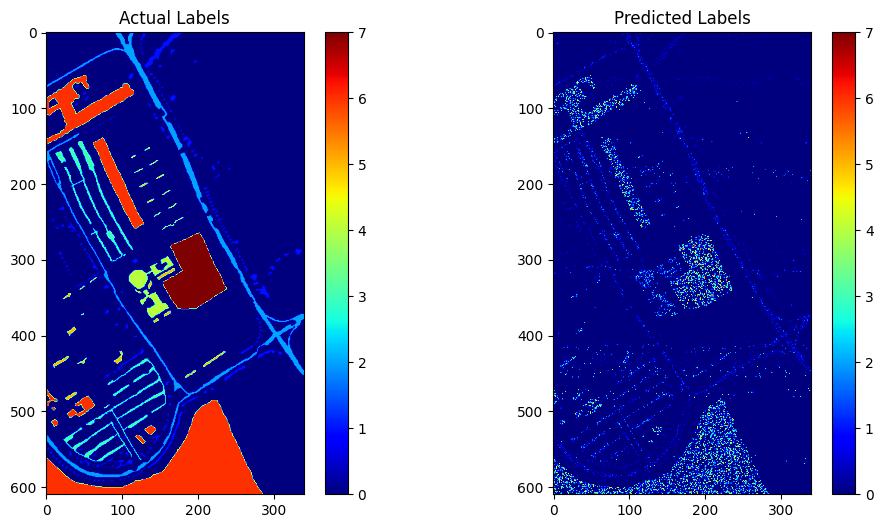

In [ ]:
# Main for Stage 3
if __name__ == "__main__":
    # Load expanded features from Stage 2
    # Xs, Xt, source_labels, pseudo_labels = load_stage2_results()

    Xs = Xs_expanded
    Xt = Xt_expanded
    # Expand features in manageable batches
    Xs_expanded = batch_feature_expansion(Xs)
    Xt_expanded = batch_feature_expansion(Xt)

    # Train Incremental Ridge Classifier on source domain features
    ridge_classifier = train_incremental_ridge_classifier(Xs_expanded, source_labels)

    # Predict on target domain features and evaluate
    final_accuracy, final_kappa, predictions = evaluate_on_target(ridge_classifier, Xt_expanded, target_labels)

    # Visualize classification results if needed
    visualize_classification_results(target_labels.numpy(), np.array(predictions), image_shape=(610, 340))
